## COVID analysis - misc code

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def label_transfer_classify(adata, n_iters = 5, split_seed=42):
    '''Train classifier on latent space to identify OOR cell state in disease cells'''
    X = adata[adata.obs['dataset_group'] == 'query'].obsm['X_scVI'].copy()
    y = adata[adata.obs['dataset_group'] == 'query'].obs['OOR_state']
    class_out = {'precision':[], 'recall':[], 'f1-score':[], 'accuracy':[], 'support':[]}
    for s in np.arange(split_seed, split_seed+n_iters):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, random_state=s)

#         clf = LogisticRegression(random_state=0).fit(X_train, y_train)
        clf = KNeighborsClassifier(n_neighbors=50, metric="euclidean").fit(X_train, y_train)
        class_out_iter = classification_report(y_test, clf.predict(X_test), output_dict=True)['1']
        class_out_iter['accuracy'] = classification_report(y_test, clf.predict(X_test), output_dict=True)['accuracy']
        for k in class_out.keys():
            class_out[k].append(class_out_iter[k])
    return(pd.DataFrame(class_out))

In [28]:
## Rename clusters by majority voting 
def label_leiden(adata, anno_col='author_cell_type_broad'):
    cmat = sc.metrics.confusion_matrix('leiden', anno_col, adata.obs)
    majority_df = pd.concat([cmat.idxmax(1), cmat.max(1)], 1)
    majority_df.columns=['label','fraction']
    adata.obs['leiden_label'] = [x + "_" + majority_df.loc[x, 'label'] for x in adata.obs['leiden']]
    adata.obs['leiden_label_frac'] = [majority_df.loc[x, 'fraction'] for x in adata.obs['leiden']]

## Leiden clustering 
sc.tl.leiden(adata, resolution=2.0)
sc.tl.leiden(adata_c, resolution=2.0)

label_leiden(adata)
label_leiden(adata_c)

... storing 'author_cell_type_broad' as categorical
... storing 'leiden_label' as categorical


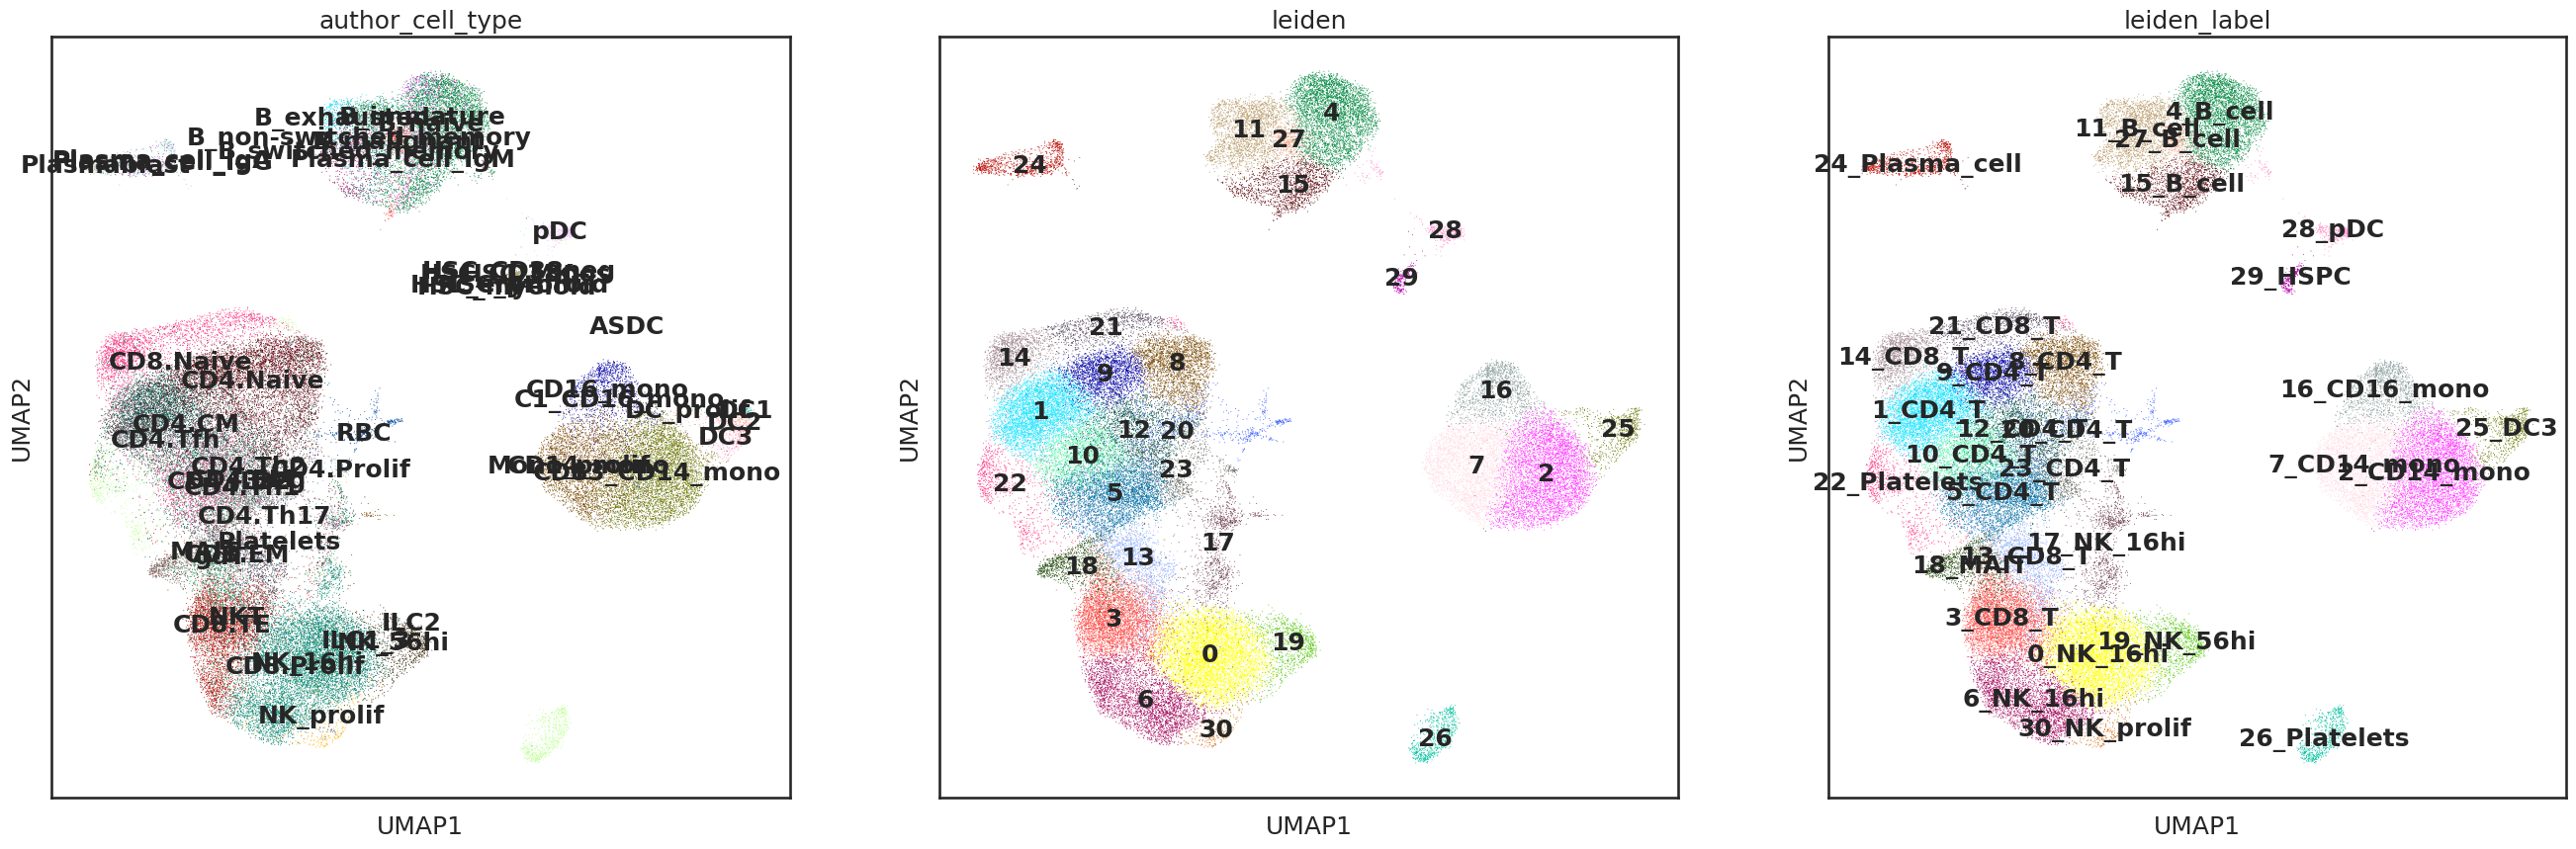

... storing 'author_cell_type_broad' as categorical
... storing 'leiden_label' as categorical


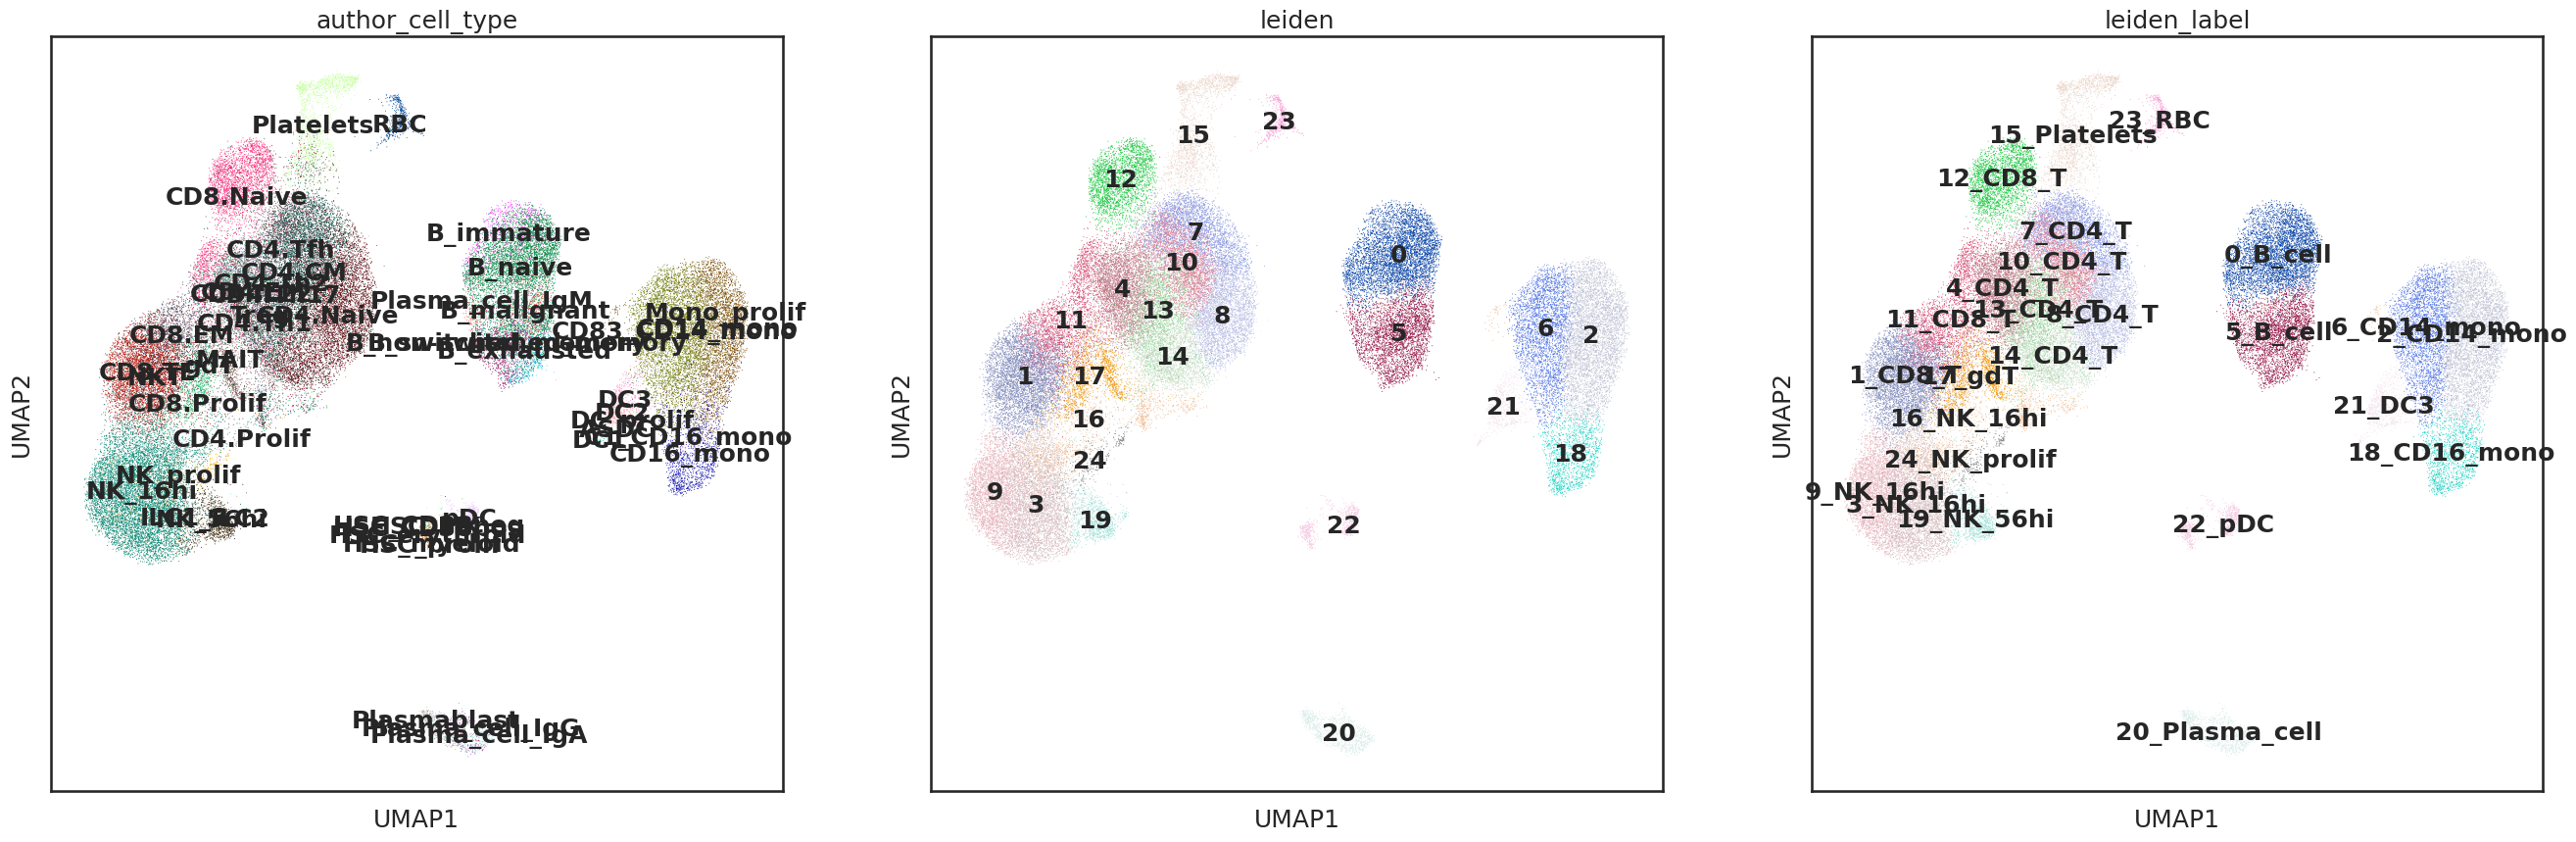

In [100]:
with rc_context({'figure.figsize':[10,10]}):
    sc.pl.umap(adata, color=['author_cell_type', 'leiden','leiden_label'], legend_loc='on data')
    sc.pl.umap(adata_c, color=['author_cell_type', 'leiden','leiden_label'], legend_loc='on data')

In [223]:
(adata.obs[['author_cell_type_broad', 'author_cell_type']]
        .drop_duplicates()
        .sort_values('author_cell_type_broad')
        ['author_cell_type'].astype('str')
        )

10_1038_s41591_021_01329_2-BGCV04_GGACGTCAGGCTAGCA-1                      ASDC
10_1038_s41591_021_01329_2-BGCV10_TCACAAGTCACTCTTA-1               B_malignant
10_1038_s41591_021_01329_2-S11_GATCTAGTCACTATTC-1                      B_naive
10_1038_s41591_021_01329_2-S11_ATCATCTAGCCAGGAT-1                   B_immature
10_1038_s41591_021_01329_2-S11_CAGCAGCTCAATCTCT-1        B_non-switched_memory
10_1038_s41591_021_01329_2-S12_AGCGGTCGTGCACGAA-1            B_switched_memory
10_1038_s41591_021_01329_2-S12_TCACGAAAGCTAGTTC-1                  B_exhausted
10_1038_s41591_021_01329_2-S11_GAGTCCGGTTCAGGCC-1                      CD4.Tfh
10_1038_s41591_021_01329_2-BGCV05_ATCGAGTCAGTCAGCC-1                  CD4.Th17
10_1038_s41591_021_01329_2-S24_CCATTCGGTCGATTGT-1                      CD4.Th2
10_1038_s41591_021_01329_2-S11_GCAATCACACCAACCG-1                     CD4.IL22
10_1038_s41591_021_01329_2-S12_TTCGGTCAGGAATGGA-1                       CD4.EM
10_1038_s41591_021_01329_2-S12_ATTGGTGCAATCTACG-1   

In [248]:
def plot_confusion(adata):
    row_order = (adata.obs[['author_cell_type_broad', 'author_cell_type']]
        .drop_duplicates()
        .sort_values('author_cell_type_broad')
        ['author_cell_type'].astype('str')
        )
        
    cmat = sc.metrics.confusion_matrix('author_cell_type', 'leiden',  adata.obs)
    # cmat.index = cmat.index.astype("category").cat.reorder_categories(row_order )
    # col_order = cmat.idxmax(0).sort_values().index
    sort_mapping = row_order.reset_index()['author_cell_type'].reset_index().set_index('author_cell_type')
    idxmax = pd.DataFrame(cmat.loc[row_order].idxmax(0))
    idxmax['map'] = idxmax[0].map(sort_mapping['index'])
    col_order = idxmax.sort_values('map').index
    sns.heatmap(cmat.loc[row_order, col_order])

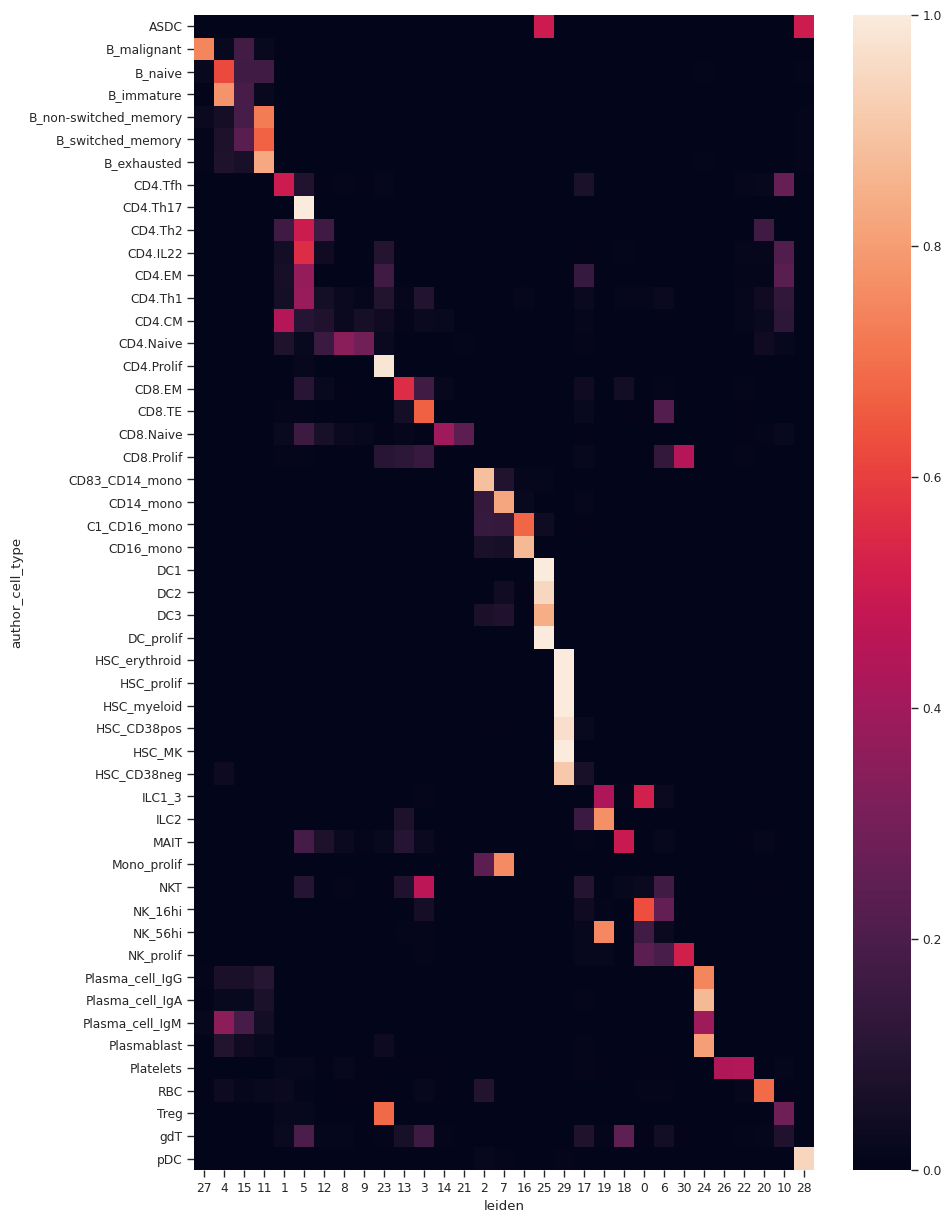

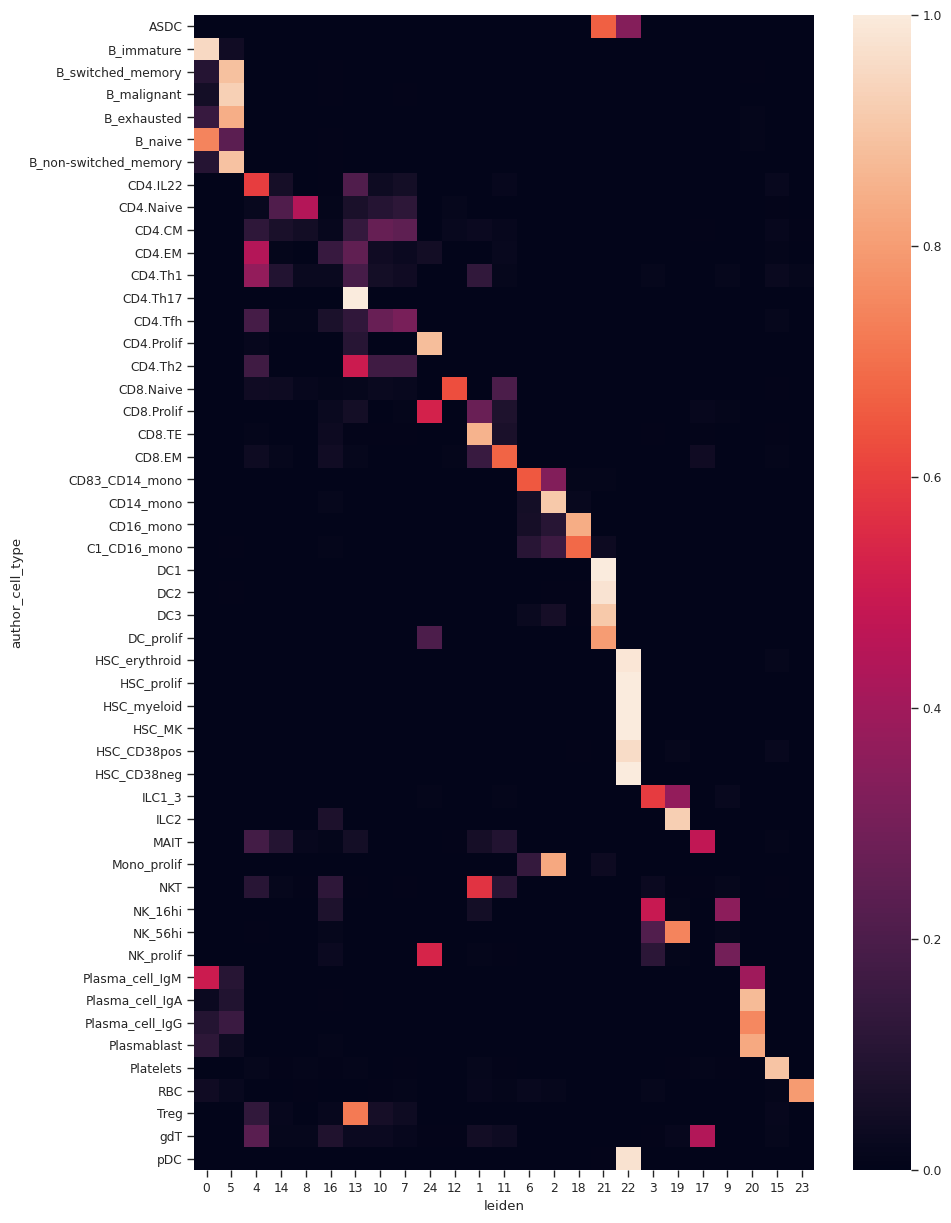

In [ ]:
with rc_context({'figure.figsize': [10,15]}):
    plot_confusion(adata)
    plt.tight_layout()
    plt.savefig(figdir + 'clustering_confusion_PAC.png')
    plt.show()
    plot_confusion(adata_c)
    plt.tight_layout()
    plt.savefig(figdir + 'clustering_confusion_PC.png')

In [259]:
from sklearn.metrics import adjusted_rand_score
nmi_PAC = adjusted_rand_score(adata.obs['author_cell_type'], adata.obs['leiden'])
nmi_PC = adjusted_rand_score(adata_c.obs['author_cell_type'], adata_c.obs['leiden'])

In [260]:
nmi_PAC

0.44920705959765295

In [261]:
nmi_PC

0.44292519025742616

In [102]:
from diff2atlas.diff_analysis_wrappers import run_sccoda
pac_sccoda_res = run_sccoda(adata, condition_col = 'dataset_group', sample_col = 'sample_id', annotation_col = 'leiden_label', ref_cell_type = 'automatic')
# run_sccoda(adata_c, condition_col = 'dataset_group', sample_col = 'donor_id', annotation_col = 'leiden_label', ref_cell_type = '1_CD4_T')


Automatic reference selection! Reference cell type set to 19_NK_56hi
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [04:39<00:00, 71.62it/s]


MCMC sampling finished. (350.142 sec)
Acceptance rate: 57.2%


In [101]:
pc_sccoda_res = run_sccoda(adata_c, condition_col = 'dataset_group', sample_col = 'sample_id', annotation_col = 'leiden_label', ref_cell_type = 'automatic')

Automatic reference selection! Reference cell type set to 19_NK_56hi
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [04:05<00:00, 81.44it/s]
6 out of the last 6 calls to <function CompositionalModel.sampling.<locals>.sample_mcmc at 0x7f4b5946b170> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


MCMC sampling finished. (309.931 sec)
Acceptance rate: 54.3%


In [86]:
pac_sccoda_res.summary()

Compositional Analysis summary:

Data: 130 samples, 31 cell types
Reference index: 11
Formula: condition

Intercepts:
                Final Parameter  Expected Sample
Cell Type                                       
0_NK_16hi                 1.002        42.600944
10_CD4_T                  0.068        16.741261
11_B_cell                 0.159        18.336185
12_CD4_T                  0.163        18.409676
13_CD8_T                  0.095        17.199433
14_CD8_T                 -0.206        12.728918
15_B_cell                -0.251        12.168813
16_CD16_mono             -0.500         9.486563
17_NK_16hi               -0.257        12.096019
18_MAIT                  -0.086        14.351815
19_NK_56hi               -0.182        13.038107
1_CD4_T                   0.451        24.554040
20_CD4_T                 -0.490         9.581905
21_CD8_T                 -0.381        10.685380
22_Platelets             -0.689         7.852849
23_CD4_T                 -0.399        10.494763


In [103]:
pc_sccoda_res.set_fdr(0.2)
pac_sccoda_res.set_fdr(0.2)

In [136]:
credible_changes = pc_sccoda_res.credible_effects()['condition[T.P]']
pc_sccoda_res.effect_df.loc[['condition[T.P]']][credible_changes.values]

Final Parameter  HDI 3%  HDI 97%     SD  \
Covariate      Cell Type                                                 
condition[T.P] 2_CD14_mono            0.447591   0.140    0.790  0.194   
               7_CD4_T               -0.302961  -0.565    0.006  0.186   
               10_CD4_T               0.459562   0.136    0.746  0.162   
               17_gdT                -0.447289  -0.766   -0.141  0.177   
               20_Plasma_cell         0.436800   0.077    0.782  0.194   
               21_DC3                -0.193721  -0.527    0.074  0.156   
               24_NK_prolif           0.187051  -0.149    0.533  0.166   

                               Inclusion probability  Expected Sample  \
Covariate      Cell Type                                                
condition[T.P] 2_CD14_mono                  0.947133        25.117126   
               7_CD4_T                      0.795067        17.993275   
               10_CD4_T                     0.998800        25.623783   
               17_gdT                       0.983667        11.736110   
               20_Plasma_cell               0.986733         9.745046   
               21_DC3                       0.526467         8.830730   
               24_NK_prolif                 0.547800         8.158088   

                               log2-fold change  
Covariate      Cell Type                         
condition[T.P] 2_CD14_mono             0.620161  
               7_CD4_T                -0.462657  
               10_CD4_T                0.637431  
               17_gdT                 -0.670877  
               20_Plasma_cell          0.604593  
               21_DC3                 -0.305057  
               24_NK_prolif            0.244281

In [109]:
credible_changes = pac_sccoda_res.credible_effects()['condition[T.P]']
pac_sccoda_res.effect_df.loc[['condition[T.P]']][credible_changes.values]

Final Parameter  HDI 3%  HDI 97%     SD  \
Covariate      Cell Type                                                 
condition[T.P] 1_CD4_T                0.203204  -0.040    0.474  0.152   
               2_CD14_mono            0.210179  -0.026    0.458  0.148   
               6_NK_16hi              0.203864  -0.045    0.456  0.150   
               7_CD14_mono            0.407795   0.087    0.735  0.191   
               18_MAIT               -0.380302  -0.687    0.001  0.212   
               24_Plasma_cell         0.395342   0.040    0.748  0.215   

                               Inclusion probability  Expected Sample  \
Covariate      Cell Type                                                
condition[T.P] 1_CD4_T                      0.706333        26.121014   
               2_CD14_mono                  0.691667        31.680943   
               6_NK_16hi                    0.657133        29.529818   
               7_CD14_mono                  0.945933        14.488145   
               18_MAIT                      0.904800         9.404935   
               24_Plasma_cell               0.914667         9.032945   

                               log2-fold change  
Covariate      Cell Type                         
condition[T.P] 1_CD4_T                 0.233087  
               2_CD14_mono             0.243150  
               6_NK_16hi               0.234040  
               7_CD14_mono             0.528249  
               18_MAIT                -0.608733  
               24_Plasma_cell          0.510284

In [146]:
credible_changes = pac_sccoda_res.credible_effects()['condition[T.P]']
pac_res_df = pac_sccoda_res.effect_df.loc[['condition[T.P]']].reset_index()
pac_res_df['is_credible'] = credible_changes.values

credible_changes = pc_sccoda_res.credible_effects()['condition[T.P]']
pc_res_df = pc_sccoda_res.effect_df.loc[['condition[T.P]']].reset_index()
pc_res_df['is_credible'] = credible_changes.values

In [143]:
## Compute mean IFN signature 
# pac_mean_IFN = adata.obs.groupby('leiden_label').mean()['IFN_signature']
# pc_mean_IFN = adata_c.obs.groupby('leiden_label').mean()['IFN_signature']

pac_mean_IFN = adata.obs.groupby(['dataset_group', 'leiden_label']).mean()['IFN_signature'].reset_index().pivot(
        columns=[ "dataset_group"],
        index=annotation_col,
        values="IFN_signature")

pc_mean_IFN = adata_c.obs.groupby(['dataset_group', 'leiden_label']).mean()['IFN_signature'].reset_index().pivot(
        columns=[ "dataset_group"],
        index=annotation_col,
        values="IFN_signature")

In [147]:
pc_res_df.index = pc_res_df['Cell Type']
pc_res_df = pd.concat([pc_res_df, pc_mean_IFN], 1)
pc_res_df['design'] = 'PC'

pac_res_df.index = pac_res_df['Cell Type']
pac_res_df = pd.concat([pac_res_df, pac_mean_IFN], 1)
pac_res_df['design'] = 'PAC'


Covariate       Cell Type  Final Parameter  HDI 3%  \
0_NK_16hi       condition[T.P]       0_NK_16hi         0.000000  -0.282   
1_CD4_T         condition[T.P]         1_CD4_T         0.203204  -0.040   
2_CD14_mono     condition[T.P]     2_CD14_mono         0.210179  -0.026   
3_CD8_T         condition[T.P]         3_CD8_T         0.000000  -0.247   
4_B_cell        condition[T.P]        4_B_cell         0.000000  -0.191   
5_CD4_T         condition[T.P]         5_CD4_T         0.000000  -0.277   
6_NK_16hi       condition[T.P]       6_NK_16hi         0.203864  -0.045   
7_CD14_mono     condition[T.P]     7_CD14_mono         0.407795   0.087   
8_CD4_T         condition[T.P]         8_CD4_T         0.000000  -0.275   
9_CD4_T         condition[T.P]         9_CD4_T         0.000000  -0.262   
10_CD4_T        condition[T.P]        10_CD4_T         0.000000  -0.138   
11_B_cell       condition[T.P]       11_B_cell         0.000000  -0.331   
12_CD4_T        condition[T.P]        12_CD4_T         0.000000  -0.279   
13_CD8_T        condition[T.P]        13_CD8_T         0.000000  -0.368   
14_CD8_T        condition[T.P]        14_CD8_T         0.000000  -0.276   
15_B_cell       condition[T.P]       15_B_cell         0.000000  -0.400   
16_CD16_mono    condition[T.P]    16_CD16_mono         0.000000  -0.479   
17_NK_16hi      condition[T.P]      17_NK_16hi         0.000000  -0.422   
18_MAIT         condition[T.P]         18_MAIT        -0.380302  -0.687   
19_NK_56hi      condition[T.P]      19_NK_56hi         0.000000   0.000   
20_CD4_T        condition[T.P]        20_CD4_T         0.000000  -0.214   
21_CD8_T        condition[T.P]        21_CD8_T         0.000000  -0.529   
22_Platelets    condition[T.P]    22_Platelets         0.000000  -0.171   
23_CD4_T        condition[T.P]        23_CD4_T         0.000000  -0.101   
24_Plasma_cell  condition[T.P]  24_Plasma_cell         0.395342   0.040   
25_DC3          condition[T.P]          25_DC3         0.000000  -0.441   
26_Platelets    condition[T.P]    26_Platelets         0.000000  -0.290   
27_B_cell       condition[T.P]       27_B_cell         0.000000  -0.334   
28_pDC          condition[T.P]          28_pDC         0.000000  -0.243   
29_HSPC         condition[T.P]         29_HSPC         0.000000  -0.161   
30_NK_prolif    condition[T.P]    30_NK_prolif         0.000000  -0.174   

                HDI 97%     SD  Inclusion probability  Expected Sample  \
0_NK_16hi         0.121  0.070               0.358067        41.245256   
1_CD4_T           0.474  0.152               0.706333        26.121014   
2_CD14_mono       0.458  0.148               0.691667        31.680943   
3_CD8_T           0.185  0.075               0.412467        27.181487   
4_B_cell          0.269  0.081               0.389067        27.675184   
5_CD4_T           0.159  0.071               0.335467        27.290430   
6_NK_16hi         0.456  0.150               0.657133        29.529818   
7_CD14_mono       0.735  0.191               0.945933        14.488145   
8_CD4_T           0.204  0.077               0.357800        18.662872   
9_CD4_T           0.219  0.082               0.410867        18.039001   
10_CD4_T          0.366  0.105               0.419600        16.519411   
11_B_cell         0.177  0.088               0.385267        17.505867   
12_CD4_T          0.198  0.083               0.409600        17.877378   
13_CD8_T          0.108  0.115               0.494733        16.735565   
14_CD8_T          0.278  0.103               0.427867        12.250125   
15_B_cell         0.172  0.126               0.526533        11.876197   
16_CD16_mono      0.112  0.146               0.503133         9.166322   
17_NK_16hi        0.121  0.131               0.562867        11.746274   
18_MAIT           0.001  0.212               0.904800         9.404935   
19_NK_56hi        0.000  0.000               0.000000        11.617773   
20_CD4_T          0.317  0.090               0.385933         9.29

In [148]:

sccoda_res_df = pd.concat([pac_res_df, pc_res_df])
sccoda_res_df


Covariate       Cell Type  Final Parameter  HDI 3%  \
0_NK_16hi       condition[T.P]       0_NK_16hi         0.000000  -0.282   
1_CD4_T         condition[T.P]         1_CD4_T         0.203204  -0.040   
2_CD14_mono     condition[T.P]     2_CD14_mono         0.210179  -0.026   
3_CD8_T         condition[T.P]         3_CD8_T         0.000000  -0.247   
4_B_cell        condition[T.P]        4_B_cell         0.000000  -0.191   
5_CD4_T         condition[T.P]         5_CD4_T         0.000000  -0.277   
6_NK_16hi       condition[T.P]       6_NK_16hi         0.203864  -0.045   
7_CD14_mono     condition[T.P]     7_CD14_mono         0.407795   0.087   
8_CD4_T         condition[T.P]         8_CD4_T         0.000000  -0.275   
9_CD4_T         condition[T.P]         9_CD4_T         0.000000  -0.262   
10_CD4_T        condition[T.P]        10_CD4_T         0.000000  -0.138   
11_B_cell       condition[T.P]       11_B_cell         0.000000  -0.331   
12_CD4_T        condition[T.P]        12_CD4_T         0.000000  -0.279   
13_CD8_T        condition[T.P]        13_CD8_T         0.000000  -0.368   
14_CD8_T        condition[T.P]        14_CD8_T         0.000000  -0.276   
15_B_cell       condition[T.P]       15_B_cell         0.000000  -0.400   
16_CD16_mono    condition[T.P]    16_CD16_mono         0.000000  -0.479   
17_NK_16hi      condition[T.P]      17_NK_16hi         0.000000  -0.422   
18_MAIT         condition[T.P]         18_MAIT        -0.380302  -0.687   
19_NK_56hi      condition[T.P]      19_NK_56hi         0.000000   0.000   
20_CD4_T        condition[T.P]        20_CD4_T         0.000000  -0.214   
21_CD8_T        condition[T.P]        21_CD8_T         0.000000  -0.529   
22_Platelets    condition[T.P]    22_Platelets         0.000000  -0.171   
23_CD4_T        condition[T.P]        23_CD4_T         0.000000  -0.101   
24_Plasma_cell  condition[T.P]  24_Plasma_cell         0.395342   0.040   
25_DC3          condition[T.P]          25_DC3         0.000000  -0.441   
26_Platelets    condition[T.P]    26_Platelets         0.000000  -0.290   
27_B_cell       condition[T.P]       27_B_cell         0.000000  -0.334   
28_pDC          condition[T.P]          28_pDC         0.000000  -0.243   
29_HSPC         condition[T.P]         29_HSPC         0.000000  -0.161   
30_NK_prolif    condition[T.P]    30_NK_prolif         0.000000  -0.174   
0_B_cell        condition[T.P]        0_B_cell         0.000000  -0.246   
1_CD8_T         condition[T.P]         1_CD8_T         0.000000  -0.287   
2_CD14_mono     condition[T.P]     2_CD14_mono         0.447591   0.140   
3_NK_16hi       condition[T.P]       3_NK_16hi         0.000000  -0.330   
4_CD4_T         condition[T.P]         4_CD4_T         0.000000  -0.276   
5_B_cell        condition[T.P]        5_B_cell         0.000000  -0.380   
6_CD14_mono     condition[T.P]     6_CD14_mono         0.000000  -0.225   
7_CD4_T         condition[T.P]         7_CD4_T        -0.302961  -0.565   
8_CD4_T         condition[T.P]         8_CD4_T         0.000000  -0.300   
9_NK_16hi       condition[T.P]       9_NK_16hi         0.000000  -0.127   
10_CD4_T        condition[T.P]        10_CD4_T         0.459562   0.136   
11_CD8_T        condition[T.P]        11_CD8_T         0.000000  -0.353   
12_CD8_T        condition[T.P]        12_CD8_T         0.000000  -0.446   
13_CD4_T        condition[T.P]        13_CD4_T         0.000000  -0.137   
14_CD4_T        condition[T.P]        14_CD4_T         0.000000  -0.307   
15_Platelets    condition[T.P]    15_Platelets         0.000000  -0.354   
16_NK_16hi      condition[T.P]      16_NK_16hi         0.000000  -0.370   
17_gdT          condition[T.P]          17_gdT        -0.447289  -0.766   
18_CD16_mono    condition[T.P]    18_CD16_mono         0.000000  -0.526   
19_NK_56hi      condition[T.P]      19_NK_56hi         0.000000   0.000   
20_Plasma_cell  condition[T.P]  20_Plasma_cell         0.436800   0.077   
21_DC3          condition[T.P]          21_DC3

In [178]:
covid_palette = {'Covid':'#fb9a99', "Healthy":'#1f78b4', 'LPS':'#fdbf6f', 'Non_covid':'#fdbf6f'}
covid_palette_df = pd.DataFrame.from_dict(covid_palette.items())

0        1
0      Covid  #fb9a99
1    Healthy  #1f78b4
2        LPS  #fdbf6f
3  Non_covid  #fdbf6f

In [179]:
%%R -i sccoda_res_df -i covid_palette_df
head(sccoda_res_df)


NameError: name 'covid_palette_df' is not defined

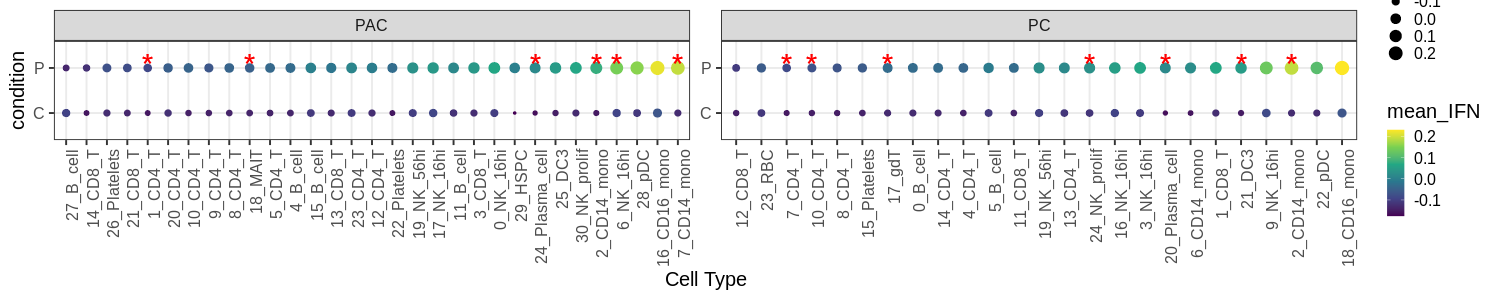

In [167]:
%%R -w 1500 -h 300
sccoda_res_df %>%
## Sort by delta in IFN signature 
arrange(P-C) %>%
mutate(`Cell Type` = factor(`Cell Type`, levels = unique(`Cell Type`))) %>%
pivot_longer(cols = c("P", "C"), names_to = "condition", values_to = "mean_IFN") %>%
ggplot(aes(`Cell Type`, condition,  color = mean_IFN, size=mean_IFN)) +
geom_point() +
geom_text(data=. %>% filter(is_credible==1), y = 2.1, nudge_y=0.6, label='*', size=10, color='red')+
scale_color_viridis_c() + 
facet_wrap(design~., scales='free') +
theme_bw(base_size=20) +
theme(axis.text.x=element_text(angle=90, vjust=1, hjust=1)) 

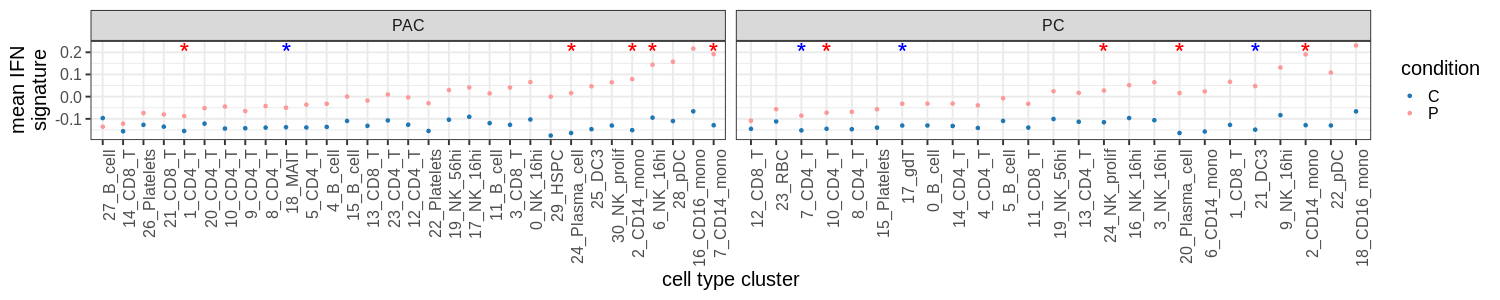

In [182]:
%%R -w 1500 -h 300 
sccoda_res_df %>%
## Sort by delta in IFN signature 
arrange(P-C) %>%
mutate(`Cell Type` = factor(`Cell Type`, levels = unique(`Cell Type`))) %>%
pivot_longer(cols = c("P", "C"), names_to = "condition", values_to = "mean_IFN") %>%
ggplot(aes(`Cell Type`, mean_IFN, color=condition)) +
geom_point(size=1.5) +
geom_text(data=. %>% filter(is_credible==1 & `log2-fold change` > 0), y = 0.21, label='*', size=8, color='red')+
geom_text(data=. %>% filter(is_credible==1 & `log2-fold change` < 0), y = 0.21, label='*', size=8, color='blue')+
# scale_color_viridis_c() + 
scale_color_manual(values=c(P = '#fb9a99', C='#1f78b4')) +
facet_wrap(design~., scales='free_x') +
theme_bw(base_size=20) +
xlab("cell type cluster") + ylab('mean IFN\nsignature') +
theme(axis.text.x=element_text(angle=90, vjust=1, hjust=1)) +



In [125]:
pac_obs_df = adata.obs.copy()
pac_obs_df['design'] = 'PAC'
pc_obs_df = adata_c.obs.copy()
pc_obs_df['design'] = 'PC'
obs_df = pd.concat([pac_obs_df, pc_obs_df])

In [134]:
%%R -i obs_df
head(obs_df)

  n_genes total_counts_mt pct_counts_mt initial_clustering Resample
1     829              25      2.224199                CD4  Initial
2    1006              22      1.007326                CD4  Initial
3    1156             101      4.732896            NK_16hi  Initial
4    1673              37      0.864284                CD8  Initial
5    1453              53      1.822558            NK_16hi  Initial
6     765              83      6.134516               CD14  Initial
  Collection_Day Swab_result Status Smoker Status_on_day_collection
1             D0    Positive  Covid Smoker                  ITU_NIV
2             D0    Positive  Covid Smoker                  ITU_NIV
3             D0    Positive  Covid Smoker                  ITU_NIV
4             D0    Positive  Covid Smoker                  ITU_NIV
5             D0    Positive  Covid Smoker                  ITU_NIV
6             D0    Positive  Covid Smoker                  ITU_NIV
  Status_on_day_collection_summary Days_from_ons

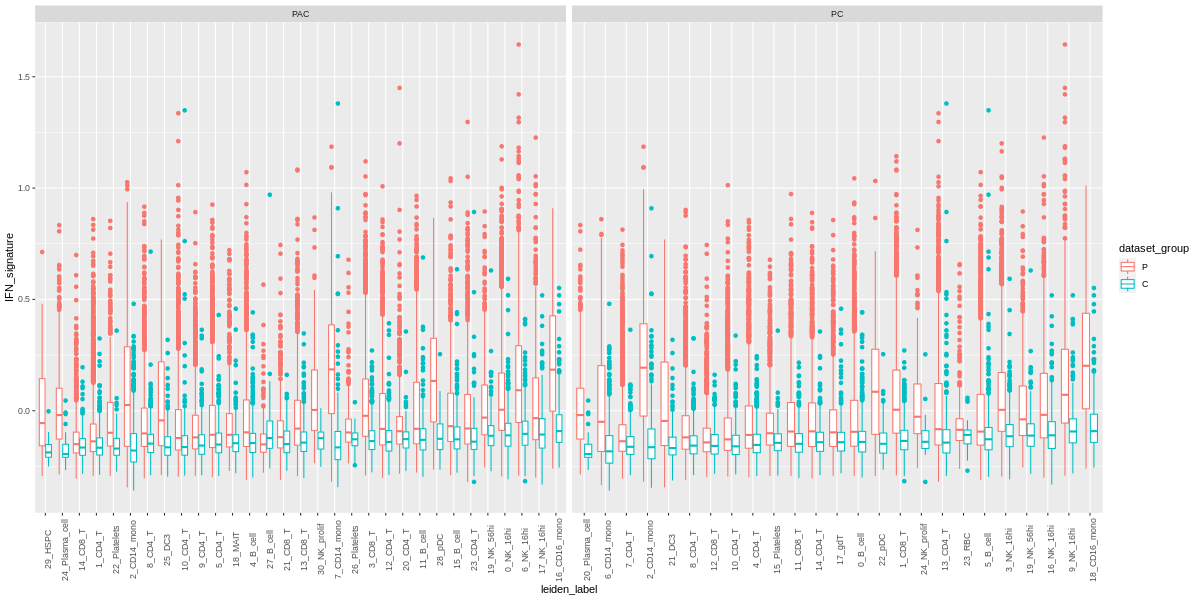

In [135]:
%%R -w 1200 -h 600
obs_df %>%
group_by(leiden_label, design, dataset_group) %>%
mutate(mean_IFN = mean(IFN_signature)) %>%
ungroup() %>%
arrange(mean_IFN) %>%
mutate(leiden_label = factor(leiden_label, levels = unique(leiden_label))) %>%
ggplot(aes(leiden_label, IFN_signature, color=dataset_group)) +
geom_boxplot() +
theme(axis.text.x=element_text(angle=90)) +
facet_wrap(design~., scales='free_x')

## Compare designs on DE analysis

In [245]:
## Leiden clustering 
sc.tl.leiden(adata, resolution=1.5)
label_leiden(adata)

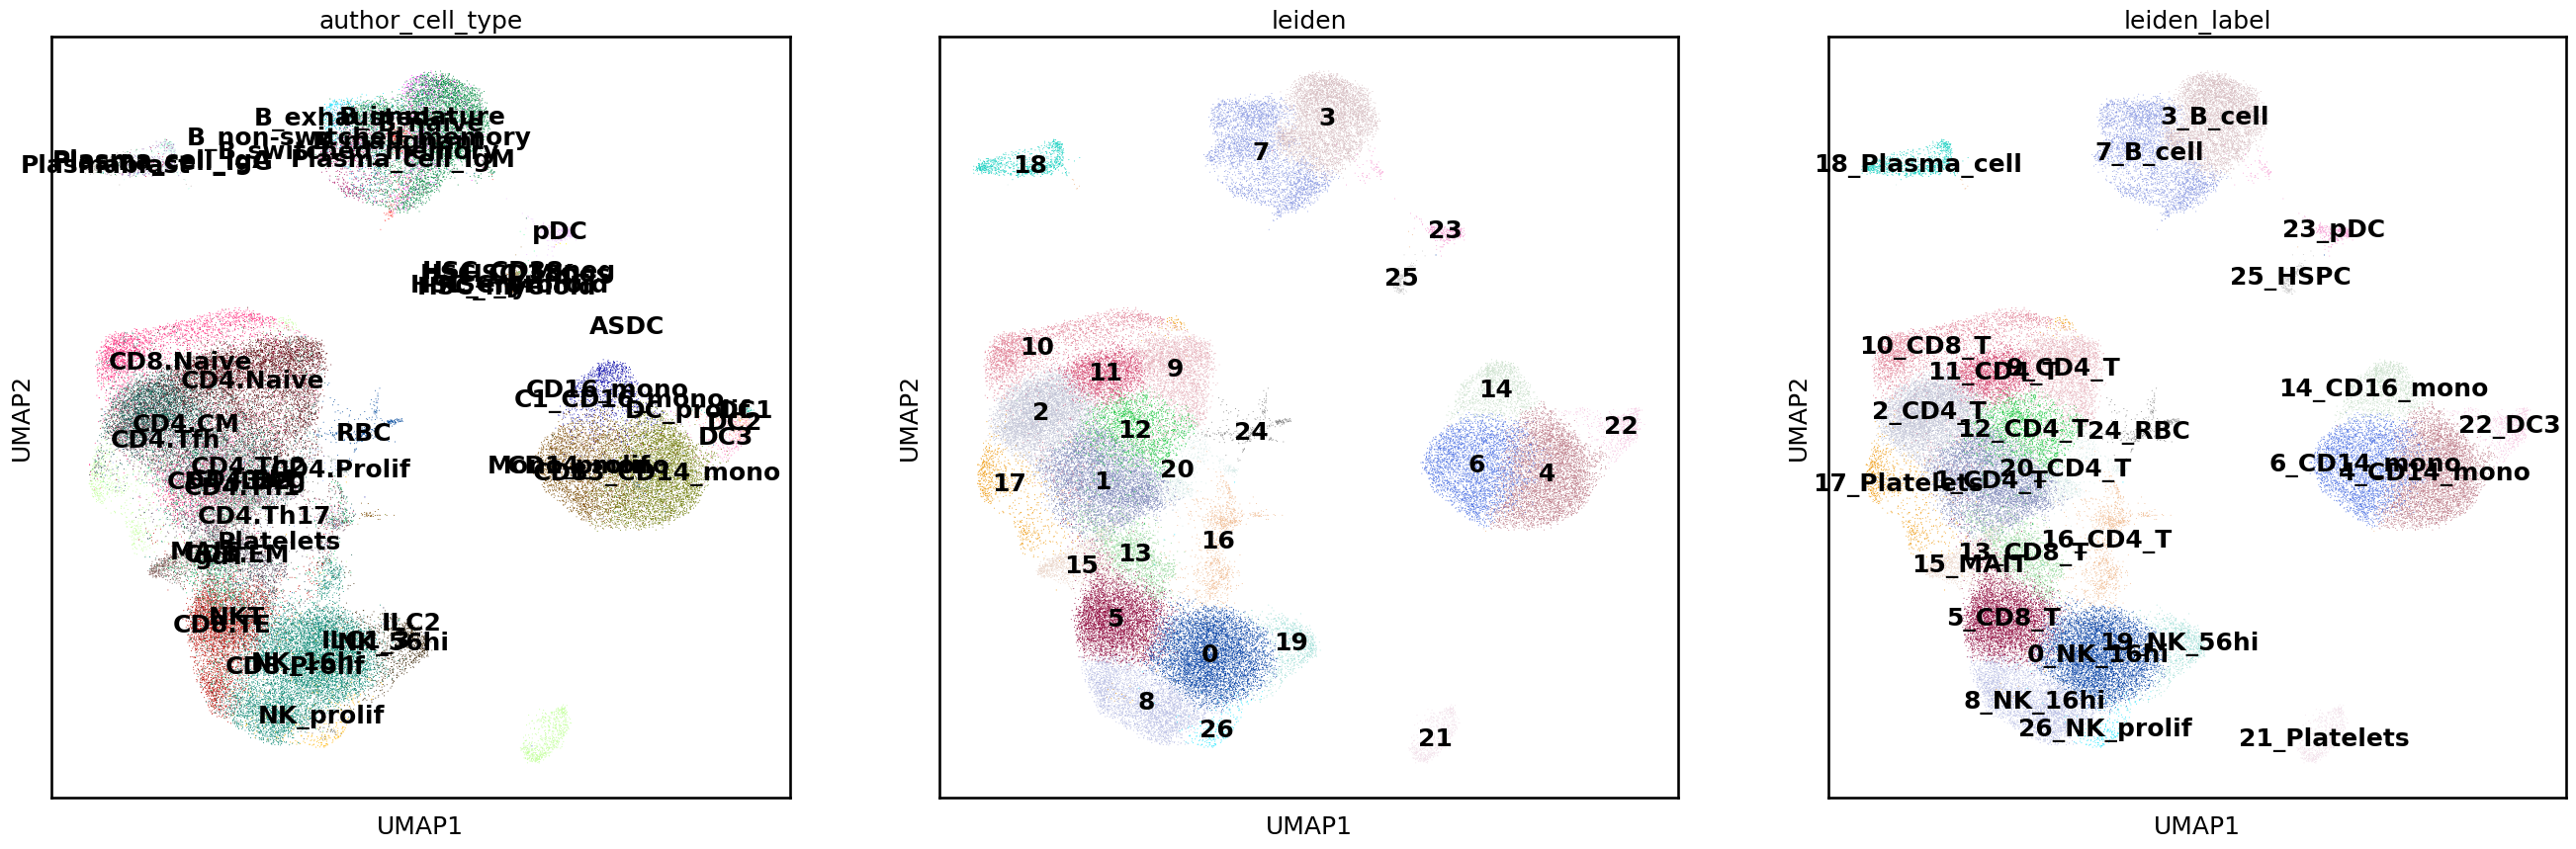

In [246]:
with rc_context({'figure.figsize':[10,10]}):
    sc.pl.umap(adata, color=['author_cell_type', 'leiden','leiden_label'], legend_loc='on data')

In [415]:
## Leiden clustering 
sc.tl.leiden(adata_c, resolution=1.5)

label_leiden(adata_c)

In [461]:
import diff2atlas

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ Site + nhood_groups',
                    ref_level = 'in_nhoods_other',
                    contrast = 'nhood_groupsin_nhoods_critical',
                     n_hvgs = 5000):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)
            
            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')
            
            
            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var, n_hvgs]
    de_res_df = r_pkg.run_de(args)
    de_res_df = pd.DataFrame(de_res_df)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name', 1, inplace=True)
    return(de_res_df)

def pseudobulk_DE(
    adata, 
    test_obs: str,
    celltype_obs: str,
    sample_obs: str,
    test_group: str,
    ctrl_group: str,
    confounders_obs = None,
    pbulk_use_layer: str = 'counts',
    n_hvgs: int = 5
    ):
    '''
    Find genes differentially expressed between cells in 2 groups of neighbourhoods
    
    Params:
    -------
    - adata: AnnData object storing nhood info in adata.uns['nhood_adata']
    - design: design formula for the test, passed to glmGamPoi
    - test_obs
    - celltype_obs
    - sample_obs
    - test_group: which neighbourhood group is the test group?
    - ctrl_group: which neighbourhood group is the reference group?
    - nhood_group_obs: the column in adata.uns['nhood_adata'] storing the neighbourhood group information
    - min_n_nhoods: cells are assigned to a neighbourhood group only if it belongs to at least min_n_nhoods neighbourhoods in the group
    - pbulk_use_layer: layer storing counts (if None, adata.X is used) 
    - n_hvgs: how many HVGS to use for the DE test (the more you use, the longer it takes)
    
    Returns:
    --------
    pd.DataFrame storing DE test results
    '''

    ## Make pseudobulk adata for cells if different nhood groups and samples
    if confounders_obs is None:
        design = f'~ {test_obs}'
        pbulk_by = [test_obs] + [sample_obs, celltype_obs]
    
    else:
        if isinstance(confounders_obs, str):
            confounder_obs = [confounders_obs]
        design = "~ " + ' + '.join(confounders_obs) + f' + {test_obs}'
        pbulk_by = [test_obs] + confounders_obs + [sample_obs, celltype_obs]
    
    pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            adata, 
            group_by = pbulk_by, 
            min_ncells = 10, 
            agg='s',
            use_layer = pbulk_use_layer)
    
    ## Filter celltypes with at least 3 replicates per condition
    n_samples = pbulk_sdata.obs[pbulk_sdata.obs[test_cov].isin([test_group, ctrl_group])].groupby([celltype_obs, test_obs]).size().reset_index()
    n_conditions = n_samples.groupby(celltype_obs).size()[0]
    min_n_samples = n_samples.groupby(celltype_obs).min()[0]
    test_celltypes = min_n_samples.index[(min_n_samples > 3) & (n_conditions == 2)]
    
    ## Run DE tests
    de_results = pd.DataFrame()
    for ct in test_celltypes:
        print(ct)
        try:
            de_results_ct = run_glmGamPoi_DE(pbulk_sdata[pbulk_sdata.obs[celltype_obs] == ct], design = design, 
                                       ref_level = ctrl_group, 
                                       contrast = f'{test_obs}{test_group}', 
                                       n_hvgs=n_hvgs)
        except:
            print("Excluded!")
            continue
        de_results_ct[celltype_obs] = ct
        de_results = pd.concat([de_results, de_results_ct])
        
    return(de_results)


In [326]:
# pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
#             adata, 
#             group_by = ['Status'] + ['Site'] + ['sample_id', 'leiden_label'], 
#             min_ncells = 10, 
#             agg='s',
#             use_layer = 'counts')

# df = pbulk_sdata.obs

# %%R -i df
# head(df)

# %%R -w 800 -h 400
# df %>%
#     ggplot(aes(sample_id, leiden_label, fill = n_cells)) +
#     geom_tile() +
#     facet_grid(.~Status, scales='free', space='free') +
#     scale_fill_viridis_c()

In [399]:
DE_results_PAC = pseudobulk_DE(adata, test_obs='Status', 
              celltype_obs='leiden_label', 
              sample_obs='sample_id',
              confounders_obs=['Site'], 
              test_group = 'Covid', 
              ctrl_group = 'Healthy',
              n_hvgs = 5000
             )

0_NK_16hi
10_CD8_T
11_CD4_T
12_CD4_T
13_CD8_T
14_CD16_mono
15_MAIT
16_CD4_T
17_Platelets
Excluded!
19_NK_56hi
1_CD4_T
22_DC3
25_HSPC
Excluded!
2_CD4_T
3_B_cell
4_CD14_mono
5_CD8_T
6_CD14_mono
7_B_cell
8_NK_16hi
9_CD4_T


In [422]:
adata_c.layers['counts'] = adata_c.X.copy()

In [445]:
from pyensembl import EnsemblRelease

## Utility function to parse 
# gene annotations from pyensembl
def ens_genes2df(genes):
    '''
    Convert pyemsembl genes to feature 
    dataframe readable by muon
    '''
    genes_df = pd.DataFrame()
    genes_df['Chromosome'] = ["chr" + x.contig for x in genes]
    genes_df['Start'] = [x.start for x in genes]
    genes_df['End'] = [x.end for x in genes]
    genes_df['GeneName'] = [x.gene_name for x in genes]
    genes_df['GeneID'] = [x.gene_id for x in genes]
    return(genes_df)

## Get gene annotations and ranges from pyensembl
data = EnsemblRelease(93)
gene_names = data.genes()
genes_df = ens_genes2df(gene_names)
genes_df.index = genes_df['GeneID'].values.copy()

In [450]:
# genes_df = adata.var.copy()
# genes_df.index = genes_df.gene_id
adata_c = adata_c[:,adata_c.var_names.isin(genes_df.index)].copy()

feature_id
ENSG00000243485    MIR1302-2HG
ENSG00000238009     AL627309.1
ENSG00000239945     AL627309.3
ENSG00000239906     AL627309.2
ENSG00000229905     AL669831.2
                      ...     
ENSG00000277196     AC007325.2
ENSG00000278384     AL354822.1
ENSG00000277856     AC233755.2
ENSG00000275063     AC233755.1
ENSG00000271254     AC240274.1
Name: GeneName, Length: 24726, dtype: object

In [459]:
adata_c.var['gene_name'] = genes_df.loc[adata_c.var_names]['GeneName'].values
adata_c.var['gene_id'] = adata_c.var_names.copy()
adata_c.var_names = adata_c.var['gene_name'].values

In [462]:
DE_results_PC = pseudobulk_DE(adata_c, test_obs='Status', 
              celltype_obs='leiden_label', 
              sample_obs='sample_id',
              confounders_obs=['Site'], 
              test_group = 'Covid', 
              ctrl_group = 'Healthy',
              n_hvgs = 5000
             )

0_NK_16hi
10_CD4_T
11_Platelets
12_NK_16hi
13_gdT
14_CD16_mono
15_NK_56hi
17_DC3
1_CD8_T
20_NK_prolif
Excluded!
2_CD4_T
3_CD4_T
4_CD4_T
5_B_cell
6_CD14_mono
7_CD14_mono
8_B_cell
9_CD8_T


In [463]:
DE_results_PC['is_IFN_gene'] = DE_results_PC.gene_name.isin(ifn_signature_genes)
DE_results_PAC['is_IFN_gene'] = DE_results_PAC.gene_name.isin(ifn_signature_genes)

In [499]:
n_ifn_DEGs = DE_results_PAC[DE_results_PAC['adj_pval'] < 0.1].groupby('leiden_label').sum('is_IFN_gene')['is_IFN_gene']
n_DEGs = DE_results_PAC[DE_results_PAC['adj_pval'] < 0.1].groupby('leiden_label').size()
(n_ifn_DEGs/len(ifn_signature_genes)).sort_values(ascending=False)

leiden_label
0_NK_16hi       1.00
4_CD14_mono     1.00
5_CD8_T         1.00
8_NK_16hi       0.96
1_CD4_T         0.96
14_CD16_mono    0.88
9_CD4_T         0.84
22_DC3          0.72
7_B_cell        0.68
6_CD14_mono     0.56
13_CD8_T        0.48
11_CD4_T        0.48
12_CD4_T        0.32
3_B_cell        0.24
2_CD4_T         0.20
10_CD8_T        0.16
19_NK_56hi      0.08
15_MAIT         0.04
16_CD4_T        0.00
Name: is_IFN_gene, dtype: float64

(array([5., 7., 2., 0., 0., 1., 1., 0., 0., 1.]),
 array([0.    , 0.0375, 0.075 , 0.1125, 0.15  , 0.1875, 0.225 , 0.2625,
        0.3   , 0.3375, 0.375 ]),
 <BarContainer object of 10 artists>)

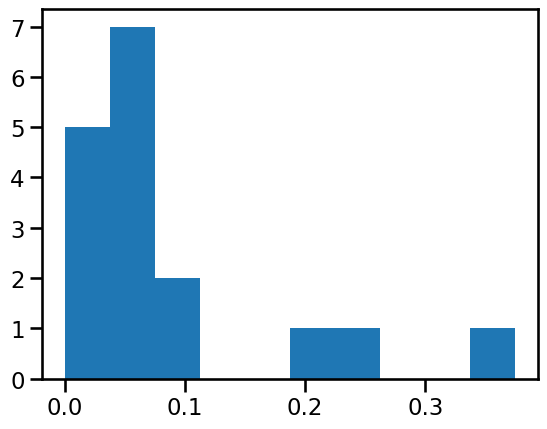

In [502]:
n_ifn_DEGs = DE_results_PC[DE_results_PC['adj_pval'] < 0.1].groupby('leiden_label').sum('is_IFN_gene')['is_IFN_gene']
n_DEGs = DE_results_PC[DE_results_PC['adj_pval'] < 0.1].groupby('leiden_label').size()
plt.hist(n_ifn_DEGs/n_DEGs)

In [477]:
%%R -i DE_results_PC -i DE_results_PAC
head(DE_results_PC)
head(DE_results_PAC)

          pval     adj_pval f_statistic df1     df2         lfc gene_name
1 9.696412e-01 0.9922648145  0.00145371   1 137.778 -0.02295457    RPS4Y1
2 5.722224e-03 0.0891312204  7.88052279   1 137.778  2.58943042  MTRNR2L8
3 5.253440e-02 0.3258957681  3.82441864   1 137.778  1.77472325       HBB
4 9.667013e-06 0.0007436164 21.11620002   1 137.778 -0.47278701     EEF1G
5 8.254903e-01 0.9545528447  0.04880078   1 137.778 -0.12747474     MYOM2
6 3.117971e-02 0.2486420202  4.73957127   1 137.778  0.78898983     PTGDS
  leiden_label is_IFN_gene
1    0_NK_16hi           0
2    0_NK_16hi           0
3    0_NK_16hi           0
4    0_NK_16hi           0
5    0_NK_16hi           0
6    0_NK_16hi           0


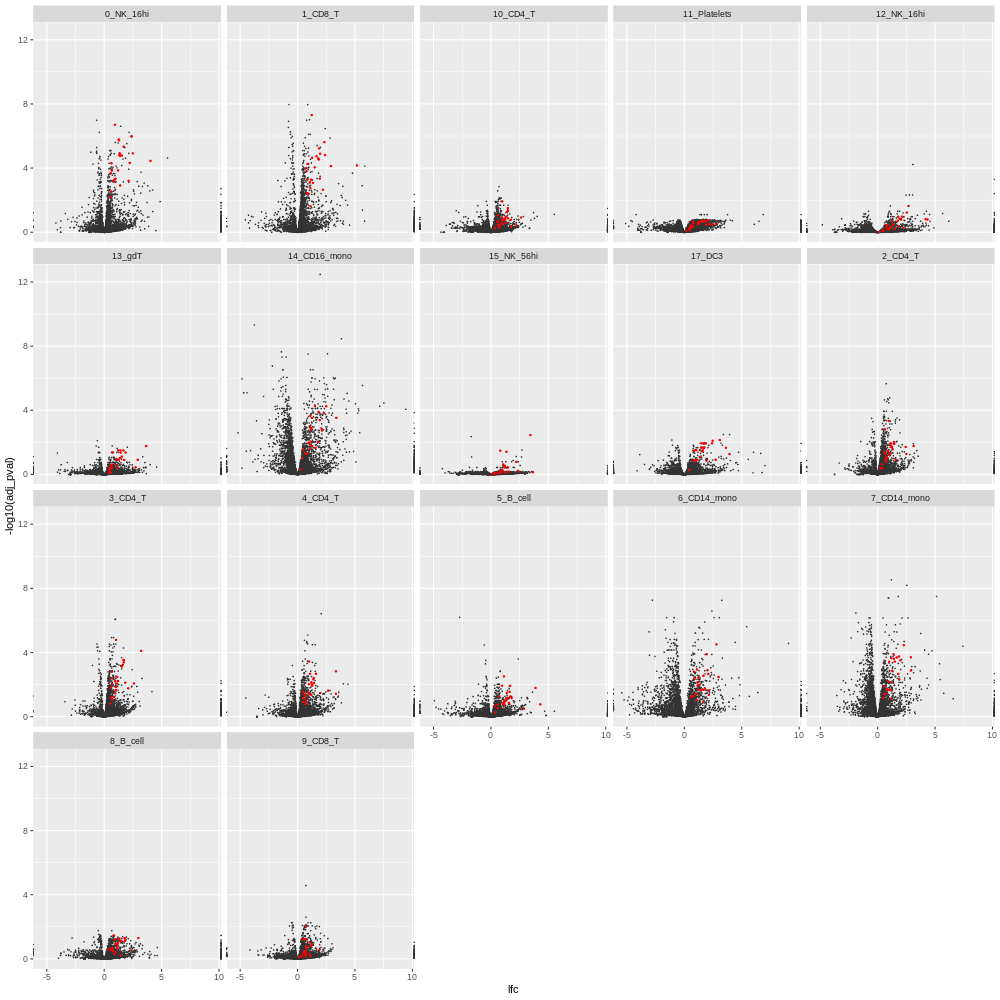

In [475]:
%%R -w 1000 -h 1000
DE_results_PC %>%
mutate(lfc = ifelse(abs(lfc) > 10, sign(lfc) * Inf, lfc)) %>%
ggplot(aes(lfc, -log10(adj_pval))) +
geom_point(size=0.1, color='grey20') +
geom_point(data=. %>% filter(is_IFN_gene), size=0.5, color='red') +
facet_wrap(leiden_label~.)

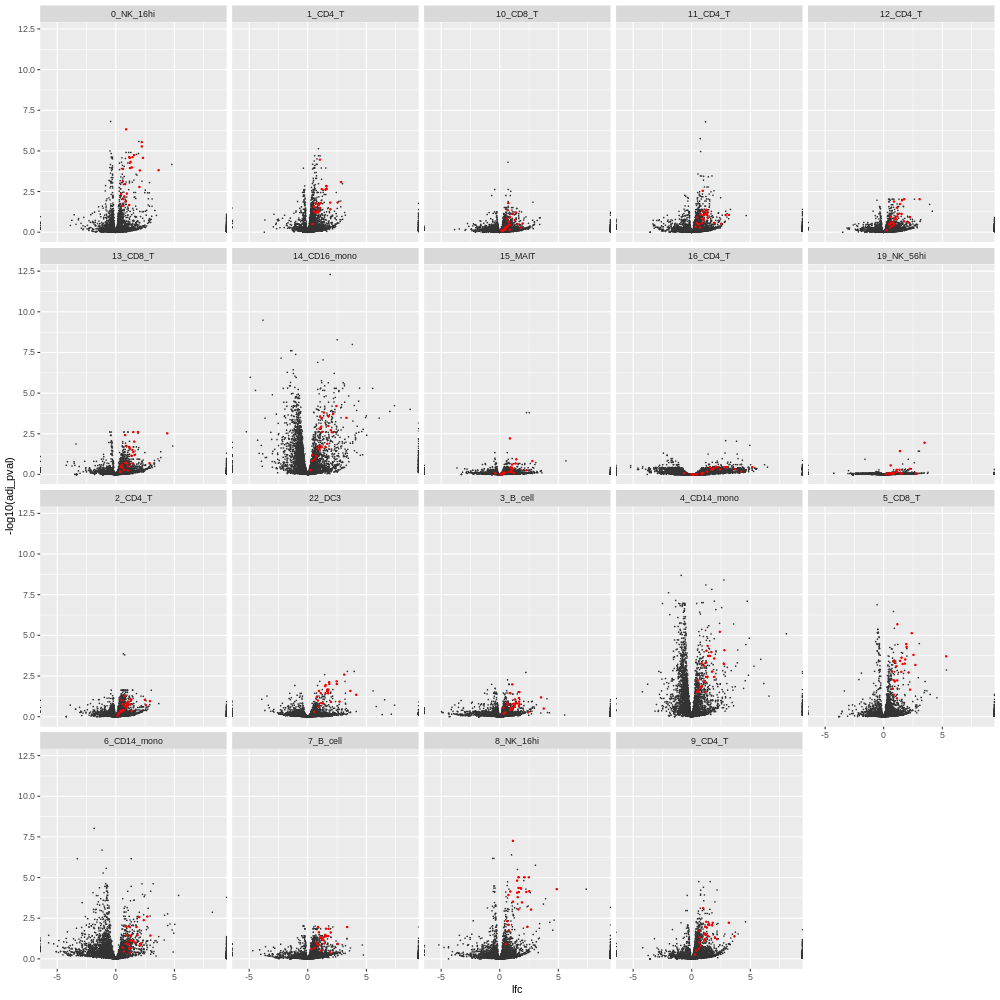

In [478]:
%%R -w 1000 -h 1000
DE_results_PAC %>%
mutate(lfc = ifelse(abs(lfc) > 10, sign(lfc) * Inf, lfc)) %>%
ggplot(aes(lfc, -log10(adj_pval))) +
geom_point(size=0.1, color='grey20') +
geom_point(data=. %>% filter(is_IFN_gene), size=0.5, color='red') +
facet_wrap(leiden_label~.)

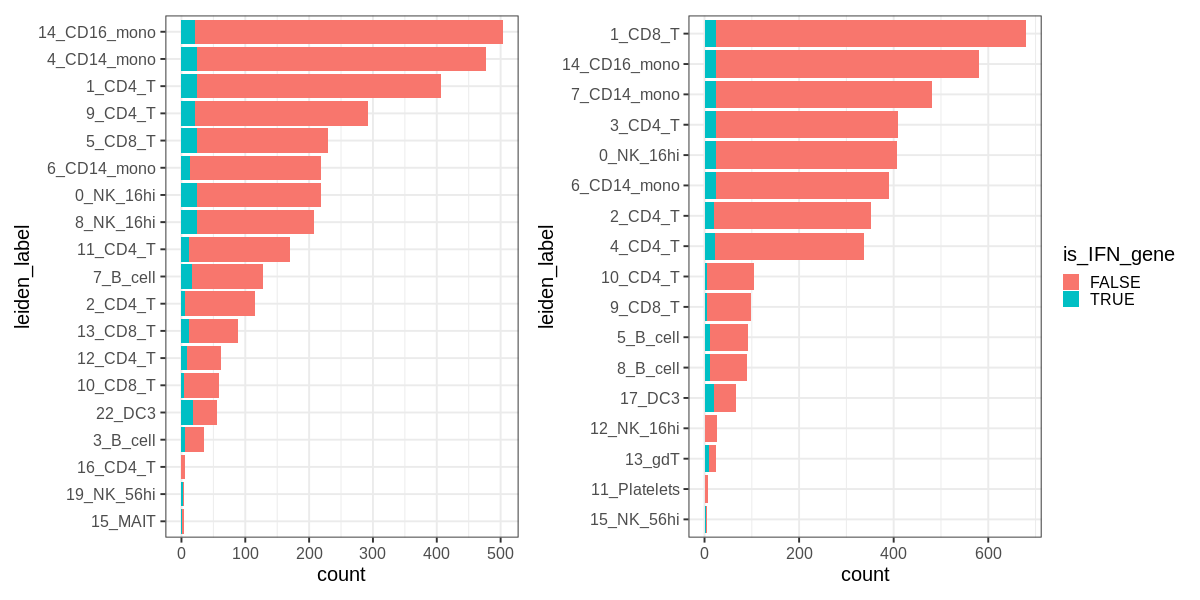

In [503]:
%%R -w 1200 -h 600
p1 <- DE_results_PAC %>%
filter((adj_pval < 0.1) & (lfc > 0)) %>%
group_by(leiden_label) %>%
mutate(n=n()) %>%
ungroup() %>%
arrange(n) %>%
mutate(leiden_label = factor(leiden_label, levels=unique(leiden_label))) %>%
ggplot(aes( leiden_label)) +
geom_bar(aes(fill=is_IFN_gene))  +
coord_flip() +
theme_bw(base_size=20)

p2 <- DE_results_PC %>%
filter((adj_pval < 0.1) & (lfc > 0)) %>%
mutate(lfc = ifelse(abs(lfc) > 10, sign(lfc) * Inf, lfc)) %>%
group_by(leiden_label) %>%
mutate(n=n()) %>%
ungroup() %>%
arrange(n) %>%
mutate(leiden_label = factor(leiden_label, levels=unique(leiden_label))) %>%
ggplot(aes( leiden_label)) +
geom_bar(aes(fill=is_IFN_gene)) +
coord_flip() +
theme_bw(base_size=20)

(p1 | p2) + plot_layout(guides='collect')

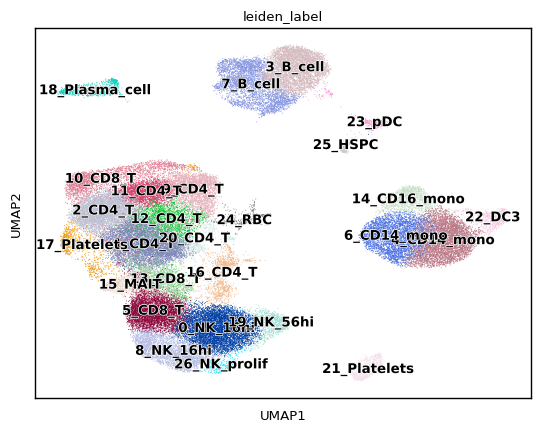

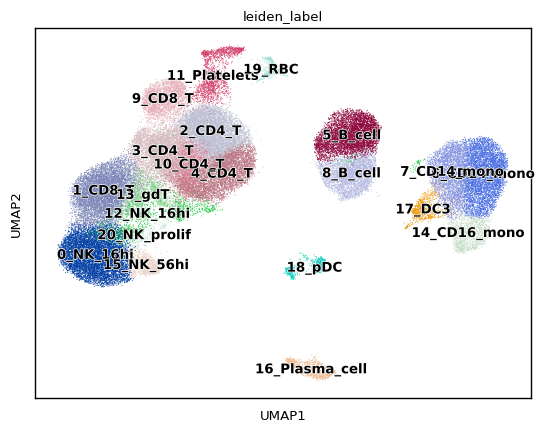

In [532]:
sns.set_context('paper')
sc.pl.umap(adata, color='leiden_label', legend_loc='on data', legend_fontoutline=1)
sc.pl.umap(adata_c, color='leiden_label', legend_loc='on data', legend_fontoutline=1)

In [ ]:
{'0_NK_16hi':'0_NK_16hi'}

In [642]:
ct_df_pc = DE_results_PC[DE_results_PC.leiden_label == '5_B_cell']
ct_df_pc['design'] = 'PC'
ct_df_pc = ct_df_pc.drop_duplicates()
ct_df_pac = DE_results_PAC[DE_results_PAC.leiden_label == '3_B_cell']
ct_df_pac['design'] = 'PAC'


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [643]:
ct_df = pd.concat([ct_df_pac, ct_df_pc])
ct_df = ct_df[['lfc', 'adj_pval', 'design', 'gene_name']]
ct_df.pivot(index='gene_name', columns='design', values=['lfc', 'adj_pval']).reset_index()

gene_name        lfc            adj_pval          
design                  PAC        PC       PAC        PC
0           A1BG  -0.261678 -0.172203  0.728817  0.764250
1        A2M-AS1  22.032041       NaN  0.764294       NaN
2         A4GALT  21.412891       NaN  0.862963       NaN
3         AARSD1   0.157762  0.366857  0.907664  0.738394
4       AASDHPPT   0.425155       NaN  0.484683       NaN
...          ...        ...       ...       ...       ...
6710     ZSCAN31  -0.311097       NaN  0.936148       NaN
6711      ZSWIM3   1.982729  2.364679  0.580623  0.373360
6712      ZSWIM7   0.512586       NaN  0.297762       NaN
6713        ZXDC   0.899610  0.671401  0.445143  0.479017
6714       ZZEF1  -0.126664 -0.122162  0.900846  0.892157

[6715 rows x 5 columns]

In [644]:
%%R -i ct_df
type(ct_df$gene_name)

[1] "character"


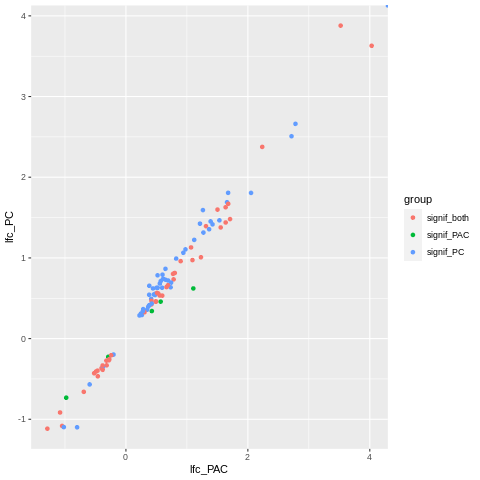

In [646]:
%%R
ct_df %>%
mutate(lfc = ifelse(abs(lfc) > 10, sign(lfc) * Inf, lfc)) %>%
# select(c('lfc', 'adj_pval', 'design', 'gene_name')) %>%
pivot_wider(values_from=c('lfc', 'adj_pval'), names_from='design') %>%
mutate(group = ifelse((adj_pval_PC < 0.1) & (adj_pval_PAC < 0.1), 'signif_both',
                      ifelse((adj_pval_PC >= 0.1) & (adj_pval_PAC < 0.1), 'signif_PAC',
                             ifelse((adj_pval_PC < 0.1) & (adj_pval_PAC >= 0.1), 'signif_PC', NA)
                     ))) %>%
filter(!is.na(group)) %>%
ggplot(aes(lfc_PAC, lfc_PC,color=group)) +
geom_point() 

In [649]:
%%R
ct_df %>%
mutate(lfc = ifelse(abs(lfc) > 10, sign(lfc) * Inf, lfc)) %>%
select(c('lfc', 'adj_pval', 'design', 'gene_name')) %>%
pivot_wider( values_from=c('lfc', 'adj_pval'), names_from='design') %>%
mutate(group = ifelse((adj_pval_PC < 0.1) & (adj_pval_PAC < 0.1), 'signif_both',
                      ifelse((adj_pval_PC >= 0.1) & (adj_pval_PAC < 0.1), 'signif_PAC',
                             ifelse((adj_pval_PC < 0.1) & (adj_pval_PAC >= 0.1), 'signif_PC', NA)
                     ))) %>%
filter(group == 'signif_PC') 

   gene_name    lfc_PAC     lfc_PC adj_pval_PAC adj_pval_PC     group
1      ISG15  1.6760638  1.8065503    0.1698918  0.07025953 signif_PC
2     S100A8  1.4207817  1.4159426    0.1145324  0.04935753 signif_PC
3        MX1  1.3888620  1.4523958    0.1467979  0.07025953 signif_PC
4     PLSCR1  1.6583847  1.6900909    0.1201010  0.05461065 signif_PC
5       OAS1  1.2710969  1.3142203    0.1917279  0.07425824 signif_PC
6      IFI44  2.7161930  2.5083319    0.1201010  0.09997556 signif_PC
7      CYB5A  0.6092389  0.7413146    0.2880564  0.09723757 signif_PC
8       OAS2  1.2145581  1.4244733    0.2514020  0.07954270 signif_PC
9       BST2  0.6466579  0.7296966    0.1467979  0.05461065 signif_PC
10     ODF3B  0.9762071  1.1055077    0.1917279  0.08441209 signif_PC
11      VCAN  2.0523548  1.8059393    0.1145324  0.05597205 signif_PC
12   MRPS18B  0.6001161  0.7921500    0.2454659  0.03293235 signif_PC
13     COPS2  0.5208265  0.6299759    0.1962470  0.05461065 signif_PC
14      RPS2 -0.3745

In [518]:
DE_signif_df = DE_results_PC[DE_results_PC.adj_pval < 0.1].copy()
n_signif_cts_PC = DE_signif_df.drop('gene_name', 1).reset_index().groupby('gene_name').size().sort_values()

DE_signif_df = DE_results_PAC[DE_results_PAC.adj_pval < 0.1].copy()
n_signif_cts_PAC = DE_signif_df.drop('gene_name', 1).reset_index().groupby('gene_name').size().sort_values()

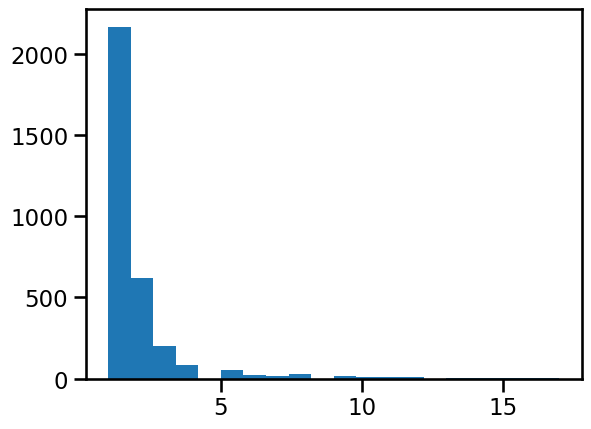

In [526]:
plt.hist(n_signif_cts_PAC, bins=20);

----